# Specifying Custom Gradients
For instructions on how to run these tutorial notebooks, please see the [index](./index.ipynb).

Drake offers automatic differentiation (AutoDiff) capabilities to solve mathematical programs.
However, there are some cases in which you will need to specify your own gradients to the optimization solver due to the problem requirements.

This tutorial will cover two ways of providing gradients: *analytically*, and *numerically* using finite differencing.

# Defining a Simple Mathematical Program
In this example, we are optimizing a simple 2-variable cost function:

$\begin{aligned}
f(x) = x_0 + \frac{3}{2} x_1
\end{aligned}$

where both variables are constrained to be in the range `[0..1]`.

Without any additional constraints, we can find the optimal solution to be `x_0 = x_1 = 0`, which yields a cost of `0`.

By adding a constraint that the solution cannot lie on a set of circles:
 * One centered at the origin with radius `0.5`
 * One centered at `x=0.75, y=-0.15` with radius `0.25`
 * One centered at `x=0.55, y=0.06` with radius `0.1`

The problem can formally be described as:

$\begin{aligned}
\min_x\hspace{10pt} \; & f(x) = x_0 + \frac{3}{2} x_1 \\
\text{subject to}\hspace{10pt} \; & x_0^2 + x_1^2 >= 0.5^2 \\
 \; & (x_0 - 0.75)^2 + (x_1 + 0.15)^2 >= 0.25^2 \\
 \; & (x_0 - 0.55)^2 + (x_1 - 0.06)^2 >= 0.1^2
\end{aligned}$

Here, we instead get an optimal solution of `x_0 = 0.48192` and `x_1 = 0.13325`, which yields a cost of `0.6818`.
This is shown in the plot below.

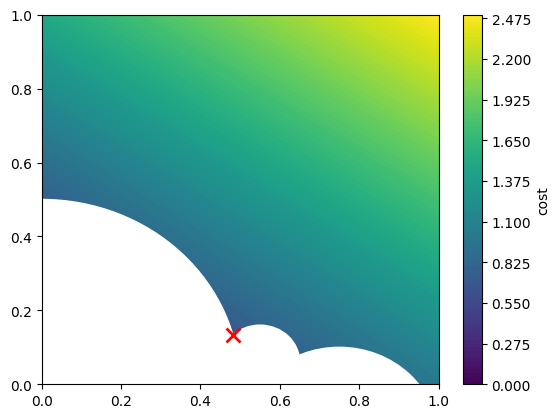

In [1]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x0 = np.linspace(0.0, 1.0, 11)
x1 = np.linspace(0.0, 1.0, 11)
X0, X1 = np.meshgrid(x0, x1)
cost = X0 + 1.5 * X1
cost_contour = ax.contourf(X0, X1, cost, levels=100)
color_bar = plt.colorbar(cost_contour)
color_bar.set_label("cost")

ax.add_patch(plt.Circle((0.0, 0.0), 0.5, color="white"))
ax.add_patch(plt.Circle((0.75, -0.15), 0.25, color="white"))
ax.add_patch(plt.Circle((0.55, 0.06), 0.1, color="white"))

ax.plot(0.48192, 0.13325, "rx", markersize=10, markeredgewidth=2)

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
plt.show()

### Solving the Program
As you have seen in the other tutorials, Drake allows you to create a `MathematicalProgram` to solve such a problem.

For simple algebraic expressions like the ones in our example, Drake's automatic differentiation (or AutoDiff) will take care of computing all the necessary gradients for the optimization solver.

In [2]:
from pydrake.solvers import MathematicalProgram, Solve

prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
prog.AddCost(x[0] + 1.5 * x[1])
prog.AddBoundingBoxConstraint(0.0, 1.0, x)
prog.AddConstraint(x[0]**2 + x[1]**2 >= 0.5**2)
prog.AddConstraint((x[0] - 0.75)**2 + (x[1] + 0.15)**2 >= 0.25**2)
prog.AddConstraint((x[0] - 0.55)**2 + (x[1] - 0.06)**2 >= 0.1**2)

result = Solve(prog, np.array([0.5, 0.5]))
print("Success? ", result.is_success())
print(result.get_solution_result())
print("x* = ", result.GetSolution(x))
print("cost = ", result.get_optimal_cost())

Success?  True
SolutionResult.kSolutionFound
x* =  [0.48191848 0.13324728]
cost =  0.6817893956447507


### Providing Your Own Analytical Gradients
For this specific example, we have already seen that providing gradients is not needed.

However, if your computations are complex enough that they are intractable or slow via Drake's automatic differentiation, or they require a third-party library incompatible with automatic differentiation, you may need to provide the gradients yourself.

In these cases, you can provide analytical gradients as shown below. For our example, we can do this because we can calculate the derivatives of the costs and constraints.

$\begin{aligned}
\frac{\partial f(x)}{\partial x} = [1, 1.5] 
\end{aligned}$

$\begin{aligned}
\frac{\partial \text{constraint}}{\partial x} = \begin{bmatrix}
2x_0 & 2x_1 \\
2(x_0 - 0.75) & 2(x_1 + 0.15) \\
2(x_0 - 0.55) & 2(x_1 - 0.06)
\end{bmatrix}
\end{aligned}$

**NOTE:** It is worth reiterating that manually specifying gradients is not necessary for this simple problem, but it serves as an illustrative example in the event that you do have a more complex use case.

In [3]:
from pydrake.autodiffutils import AutoDiffXd, ExtractGradient, ExtractValue, InitializeAutoDiff

def cost_expression(x):
    if x.dtype == float:
        # The cost expression with floats.
        return x[0] + 1.5 * x[1]
    else:
        # Extract the values from the AutoDiffXd object
        x_value = ExtractValue(x).flatten()
        x_grad = ExtractGradient(x)

        # Compute the cost and gradient
        y_value = x_value[0] + 1.5 * x_value[1]
        y_grad = np.array([1.0, 1.5]) @ x_grad

        # Return the new AutoDiffXd object with the cost and gradient
        return AutoDiffXd(y_value, y_grad)

def constraint_expression(x):
    if x.dtype == float:
        # The constraint expression with floats
        return np.array([
            x[0]**2 + x[1]**2,
            (x[0] - 0.75)**2 + (x[1] + 0.15)**2,
            (x[0] - 0.55)**2 + (x[1] - 0.06)**2,
        ])
    else:
        # Extract the values from the AutoDiffXd object
        x_value = ExtractValue(x).flatten()
        x_grad = ExtractGradient(x)

        # Compute the constraint and gradient (with chain rule)
        y_value = np.array([
            x_value[0]**2 + x_value[1]**2,
            (x_value[0] - 0.75)**2 + (x_value[1] + 0.15)**2,
            (x_value[0] - 0.55)**2 + (x_value[1] - 0.06)**2,
        ])
        y_grad = 2.0 * np.array([
            [x_value[0], x_value[1]],
            [(x_value[0] - 0.75), (x_value[1] + 0.15)],
            [(x_value[0] - 0.55), (x_value[1] - 0.06)],
        ]) @ x_grad

        # Return the new AutoDiffXd object with the constraint and gradient
        return InitializeAutoDiff(y_value, y_grad)

prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
prog.AddCost(cost_expression, x)
prog.AddBoundingBoxConstraint(0.0, 1.0, x)

# For an expression-based constraint, the lower and upper bounds must also be numpy arrays
lb = np.array([0.5**2, 0.25**2, 0.1**2])
ub = np.array([np.inf, np.inf, np.inf])
prog.AddConstraint(constraint_expression, lb, ub, x)

result = Solve(prog, np.array([0.5, 0.5]))
print("Success? ", result.is_success())
print(result.get_solution_result())
print("x*= ", result.GetSolution(x))
print("cost = ", result.get_optimal_cost())

Success?  True
SolutionResult.kSolutionFound
x*=  [0.48191848 0.13324729]
cost =  0.6817894065645409


### Calculating Gradients using Finite Differencing
In other cases, you may not have analytical gradients to provide to the solver.

You can always rely on *finite differencing* to numerically approximate the gradients by evaluating the expression at the nominal value, as well as at variable values slightly perturbed from the nominal values.

Please note that you should only rely on finite differencing when absolutely necessary, as evaluating your cost and constraint functions multiple times can drastically slow down the optimization process.

In [4]:
from pydrake.math import ComputeNumericalGradient, NumericalGradientMethod, NumericalGradientOption

def cost_fn(x):
    # This must return a numpy array to be compatible with numerical gradient extraction
    return np.array([x[0] + 1.5 * x[1]])

def cost_expression(x):
    if x.dtype == float:
        # The cost expression with floats.
        return x[0] + 1.5 * x[1]
    else:
        # Extract the values from the AutoDiffXd object
        x_value = ExtractValue(x)
        x_grad = ExtractGradient(x)

        # Compute the cost and approximate gradient
        # We are using forward differencing here as the `option` argument.
        y_value = cost_fn(x_value)
        y_grad = ComputeNumericalGradient(
            cost_fn, x_value, option=NumericalGradientOption(NumericalGradientMethod.kForward)
        ) @ x_grad

        # Return the new AutoDiffXd object with the cost and gradient
        return AutoDiffXd(y_value[0,0], y_grad[0,:])

def constraint_fn(x):
    return np.array([
        x[0]**2 + x[1]**2,
        (x[0] - 0.75)**2 + (x[1] + 0.15)**2,
        (x[0] - 0.55)**2 + (x[1] - 0.06)**2,
    ])

def constraint_expression(x):
    if x.dtype == float:
        # The constraint expression with floats
        return constraint_fn(x)
    else:
        # Extract the values from the AutoDiffXd object
        x_value = ExtractValue(x)
        x_grad = ExtractGradient(x)

        # Compute the constraint and approximate gradient
        # We are using central differencing here as the `option` argument.
        y_value = constraint_fn(x_value)
        y_grad = ComputeNumericalGradient(
            constraint_fn, x_value, option=NumericalGradientOption(NumericalGradientMethod.kCentral)
        ) @ x_grad
        
        # Return the new AutoDiffXd object with the constraint and gradient
        return InitializeAutoDiff(y_value, y_grad)
                                  
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
prog.AddCost(cost_expression, x)
prog.AddBoundingBoxConstraint(0.0, 1.0, x)

# For an expression-based constraint, the lower and upper bounds must also be numpy arrays
lb = np.array([0.5**2, 0.25**2, 0.1**2])
ub = np.array([np.inf, np.inf, np.inf])
prog.AddConstraint(constraint_expression, lb, ub, x)

result = Solve(prog, np.array([0.5, 0.5]))
print("Success? ", result.is_success())
print(result.get_solution_result())
print("x*= ", result.GetSolution(x))
print("cost = ", result.get_optimal_cost())

Success?  True
SolutionResult.kSolutionFound
x*=  [0.48191848 0.13324729]
cost =  0.681789406564469
